# Data Preparation

In [1]:
import pandas as pd

train_data = pd.read_csv('training_set.csv')
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']

test_data = pd.read_csv('testing_set.csv')
X_test = test_data.drop('target', axis=1) 
y_test = test_data['target']

print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Testing features shape:", X_test.shape)
print("Testing target shape:", y_test.shape)
print("Data preparation completed")

Training features shape: (1120, 20)
Training target shape: (1120,)
Testing features shape: (280, 20)
Testing target shape: (280,)
Data preparation completed


In [2]:
if 'target' in train_data.columns:
    unique_labels = train_data['target'].unique()
    print("Unique labels in the 'target' column train:", unique_labels)
else:
    print("'target' column not found in the dataset. Available columns are:")
    print(train_data.columns)

if 'target' in test_data.columns:
    unique_labels = test_data['target'].unique()
    print("Unique labels in the 'target' column test:", unique_labels)
else:
    print("'target' column not found in the dataset. Available columns are:")
    print(test_data.columns)

Unique labels in the 'target' column train: [1 2]
Unique labels in the 'target' column test: [1 2]


In [3]:
if isinstance(y_test, pd.Series):
    if set(y_test.unique()).issubset({1, 2}):
        y_test = y_test.map({1: 0, 2: 1})
        print("Labels in the 'target' column of test have been updated to 0 and 1.")
        print("Updated unique labels:", y_test.unique())
    else:
        print("The 'target' column in test contains unexpected values. Unique values are:", y_test.unique())
else:
    print("'target' column not found or is not a pandas Series.")

if isinstance(y_train, pd.Series):
    if set(y_train.unique()).issubset({1, 2}):
        y_train = y_train.map({1: 0, 2: 1})
        print("Labels in the 'target' column of train have been updated to 0 and 1.")
        print("Updated unique labels:", y_train.unique())
    else:
        print("The 'target' column in train contains unexpected values. Unique values are:", y_train.unique())
else:
    print("'target' column not found or is not a pandas Series.")

Labels in the 'target' column of test have been updated to 0 and 1.
Updated unique labels: [0 1]
Labels in the 'target' column of train have been updated to 0 and 1.
Updated unique labels: [0 1]


# Simulate Reservoir
Based on the transverse-field Ising Hamiltonian: $$H^k​=∑​_{i<j}J_{ij}​σ^x_i​σ^x_j​+h∑_i​σ^z_i​+h_k​∑_i​σ^x_i​$$

Where $J_{ij}$ are the coupling constants, $h$ is a static magnetic field, $h_k$ is an additional magnetic field modulated by input vectors $s_k$ at the $k$-th value, $h_k = C_s * s_k$ where $C_s$ is a scaling factor, and $s_k$ = is the input vector.

After the reservoir states are measured (giving us the measurement vector: $m_k$) using the selected set of observables, the reservoir states are augmented with the following classical post-processing equation: $$r_k=γS^{n_S}r_{k-1}+B^{l_r}m_k$$

Where $S^{n_S}$ is a cyclic shift operator acting on the reservoir state at the previous ( $k-1th$) step shifting it by $n_S$-length elements, $B^{l_r}$ is a lengthening operator acting on the measurement vector ($m_k$) by interleaving zeros between the elements such that its final length is equal to $l_r$, and $γ$ is a real-valued weight operator between $0$ and $1$ that weighs the reservoir state at the previous step.

The final reservoir states $r_k$ are compiled and used to compute the weight matrix $w$.

In [4]:
import numpy as np
import pennylane as qml
from scipy.sparse import csr_matrix

# Define constants and parameters
n_qubits = 20  # Number of qubits, should match number of features, max 25
J = 1.0       # Coupling constant range
h = 0.2 * J   # Static magnetic field

# Randomly generate coupling constants within range [-J, J]
np.random.seed(42)
Jij = np.random.uniform(-J, J, (n_qubits, n_qubits))

# Define the Ising Hamiltonian with input vector "sk"
def ising_hamiltonian(sk, Cs):
    """Construct the Hamiltonian H_k."""

    if len(sk) != n_qubits:
        raise ValueError(f"Input vector length {len(sk)} does not match n_qubits {n_qubits}.")

    H_terms = []
    # Interaction terms Jij sigma_x^i sigma_x^j
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):  
            H_terms.append((Jij[i, j], qml.PauliX(i) @ qml.PauliX(j)))

    # Static magnetic field h sigma_z^i
    for i in range(n_qubits):
        H_terms.append((h, qml.PauliZ(i)))

    # Input-dependent field h_k sigma_x^i
    for i in range(n_qubits):
        H_terms.append((Cs * sk[i], qml.PauliX(i)))  # Cs * sk[i] scales each input

    return qml.Hamiltonian(*zip(*H_terms))

In [5]:
# Cyclic Permutation Operator: nS
def cyclic_permutation(vec, nS):
    """Applies a cyclic permutation to the input vector."""
    return np.roll(vec, nS)

# Lengthening Operator: lr
def lengthening_operator(vec, lr):
    """Expands the vector to length lr by interleaving zeros."""
    lengthened = np.zeros(lr)
    step = max(1, lr // len(vec))
    indices = np.arange(0, lr, step)[:len(vec)]  # Limit indices to the vector's length
    lengthened[indices] = vec  # Map the vector elements to the lengthened vector
    return lengthened

def normalize_features(features, new_min=-1, new_max=1, epsilon=1e-25, normalize_to_unit_l2=False):
    """
    Row-by-row min-max scaling: 
      - Ignores zeros for min-max
      - Preserves zeros in the output
      - Maps min nonzero -> new_min, max nonzero -> new_max
    """

    features = np.asarray(features, dtype=np.float64)
    
    if np.isnan(features).any():
        raise ValueError("Input features contain NaN values.")
    if len(features.shape) != 2:
        raise ValueError("Input features must be a 2D array.")
    
    normalized_features = np.zeros_like(features)
    
    # Optional L2 normalization (bypasses the min-max logic if True)
    if normalize_to_unit_l2:
        return normalize_to_l2(features)

    for i in range(features.shape[0]):
        row = features[i, :]
        zero_mask = (row == 0)
        
        # Extract non-zero values
        nonzeros = row[~zero_mask]
        
        # If there are no non-zero values leave as is
        if len(nonzeros) == 0:
            normalized_features[i, :] = row
            continue
        
        min_val = np.min(nonzeros)
        max_val = np.max(nonzeros)

        if np.isclose(max_val, min_val, rtol=1e-30, atol=1e-30):
            if np.isclose(min_val, 0, atol=1e-30):
                normalized_features[i, :] = 0
            else:
                # Otherwise set non-zeros to midpoint
                midpoint = 0.5*(new_min + new_max)
                temp_row = np.full_like(row, midpoint)
                temp_row[zero_mask] = 0.0
                normalized_features[i, :] = temp_row
        else:
            # Scale from [min_val, max_val] -> [0, 1]
            scaled_nonzeros = (nonzeros - min_val) / max((max_val - min_val), epsilon)

            # [0,1] -> [new_min, new_max]
            scaled_nonzeros = new_min + (new_max - new_min)*scaled_nonzeros

            new_row = np.zeros_like(row)
            new_row[~zero_mask] = scaled_nonzeros
            normalized_features[i, :] = new_row
    
    return normalized_features

def normalize_to_l2(features, epsilon=1e-25):
    """
    Normalizes features to have unit L2 norm per row.

    Parameters:
        features (np.ndarray or csr_matrix): Input feature matrix.
        epsilon (float): Small value to avoid division by zero for small norms.

    Returns:
        np.ndarray: L2-normalized feature matrix.
    """
    if isinstance(features, csr_matrix):
        # Sparse matrix handling
        norms = np.sqrt(features.multiply(features).sum(axis=1))
        norms = np.asarray(norms).flatten()
        norms = np.maximum(norms, epsilon)

        row_indices, col_indices = features.nonzero()
        normalized_data = features.data / norms[row_indices]

        dense_result = np.zeros(features.shape, dtype=np.float64)
        dense_result[row_indices, col_indices] = normalized_data.astype(np.float64)

        return dense_result
    else:
        # Dense matrix handling
        norms = np.linalg.norm(features, axis=1, keepdims=True)
        norms = np.maximum(norms, epsilon)

        normalized_features = features / norms
        normalized_features[features == 0] = 0  

        return normalized_features.astype(np.float64)

In [6]:
# Pennylane Quantum Node
dev = qml.device("lightning.qubit", wires=n_qubits)
@qml.qnode(dev)
def quantum_reservoir(sk, Delta_t, Cs, observables="x"):
    """
    Simulate the quantum reservoir with choice of observables.
    observables:
      - "x": Measure sigma_x for all qubits
      - "xx": Measure sigma_x^i for i={1...N} AND sigma_x^i sigma_x^j for all i, j
      - "1-n": Measure sigma_{x, y, z} AND sigma_alpha^i sigma_alpha^j where j>1 combination
      - "n": Measure sigma_{x, y, z}_i for all i={1...N}
      - "a": Measure sigma_{x, y, z}_i AND sigma_x^i sigma_y^j combinations
    """
    # Prepare initial state |psi_0> as |0...0>
    qml.BasisState(np.zeros(n_qubits, dtype=int), wires=range(n_qubits))
    
    if len(sk) != n_qubits:
        raise ValueError(f"Input vector sk length ({len(sk)}) does not match n_qubits ({n_qubits}).")
    
    # Define and apply Hamiltonian evolution
    H = ising_hamiltonian(sk, Cs)

    qml.ApproxTimeEvolution(H, Delta_t, 1)  # Choose a higher level Trotter for increased stability
    
    measurements = []

    if observables == "x":
         measurements = [
             qml.expval(qml.PauliX(i)) for i in range(n_qubits)
        ]

    elif observables == "xx":
        measurements = [
                qml.expval(qml.PauliX(i)) for i in range(n_qubits)
            ] + [
                qml.expval(qml.PauliX(i) @ qml.PauliX(j)) 
                for i in range(n_qubits) for j in range(i + 1, n_qubits)
        ]

    elif observables == "1-n":
        measurements = [
             # Single-spin measurements for the first qubit
                qml.expval(qml.PauliX(0)),
                qml.expval(qml.PauliY(0)),
                qml.expval(qml.PauliZ(0))
            ] + [
                # Correlations between the first qubit (i = 0) and all other qubits (j > 0)
                qml.expval(qml.PauliX(0) @ qml.PauliX(j)) for j in range(1, n_qubits)
            ] + [
                qml.expval(qml.PauliY(0) @ qml.PauliY(j)) for j in range(1, n_qubits)
            ] + [
                qml.expval(qml.PauliZ(0) @ qml.PauliZ(j)) for j in range(1, n_qubits)
        ]

    elif observables == "n":
        measurements = [
            qml.expval(op)
            for op in [
                qml.PauliX(i) for i in range(n_qubits)
            ] + [
                qml.PauliY(i) for i in range(n_qubits)
            ] + [
                qml.PauliZ(i) for i in range(n_qubits)
            ]
        ]    
    
    elif observables == "a":
        measurements = [
            qml.expval(op)
            for op in [
                # Single-spin measurements for all qubits
                qml.PauliX(i) for i in range(n_qubits)
            ] + [
                qml.PauliY(i) for i in range(n_qubits)
            ] + [
                qml.PauliZ(i) for i in range(n_qubits)
            ] + [
                qml.PauliX(i) @ qml.PauliX(j)
                for i in range(n_qubits) for j in range(i + 1, n_qubits)
            ] + [
                qml.PauliY(i) @ qml.PauliY(j)
                for i in range(n_qubits) for j in range(i + 1, n_qubits)
            ] + [
                qml.PauliZ(i) @ qml.PauliZ(j)
                for i in range(n_qubits) for j in range(i + 1, n_qubits)
            ]
        ]

    return measurements

# Simulate the reservoir and apply classical post-processing steps
def simulate_reservoir(input_sequence, Delta_t, gamma, Cs, lr, nS, observables="x"):
    """Simulate the reservoir with classical post-processing."""
    r_prev = np.zeros(lr)
    reservoir_states = []

    if observables not in ["x", "xx", "1-n", "n", "a"]:
        raise ValueError(f"Invalid observables type: {observables}")

    for sk in input_sequence:

        # Quantum measurement vector of observables (m_k)
        m_k = quantum_reservoir(sk, Delta_t, Cs, observables=observables)

        # Apply lengthening operator
        if len(sk) > lr:
            m_k_lengthened = m_k
        else:
            m_k_lengthened = lengthening_operator(m_k, lr)

         # Update reservoir state with cyclic permutation and memory weight
        r_k = gamma * cyclic_permutation(r_prev, nS) + m_k_lengthened

        reservoir_states.append(r_k)
        
        # Update previous state
        r_prev = r_k

    return reservoir_states

# Compute Weights
Calculates binary cross-entropy loss with Adam optimizer to compute the weight matrix.

Predictions are computed using the following equation: $ŷ=$ sigmoid $(w⋅r_k)$ where $w$ is the weight matrix.

In [7]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn.init as init

# Sigmoid
def sigmoid(x):
    """Compute the sigmoid of x."""
    return 1 / (1 + np.exp(-x))

# Binary cross-entropy loss
def binary_cross_entropy_loss(y_true, y_pred, epsilon=1e-12):
    """Compute the binary cross-entropy loss with adjustable epsilon."""
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

def optimize_weights_adam(reservoir_states, labels, learn_r=0.01, epochs=100, tolerance=1e-3, weight_decay=1e-5, patience=10):
    """
    Optimize weights using binary cross-entropy loss and Adam optimizer with MPS support.
    
    Args:
        reservoir_states (np.ndarray): Reservoir states as input features.
        labels (np.ndarray): Binary labels (0 or 1).
        learn_r (float): Learning rate for weight updates.
        epochs (int): Number of optimization iterations.
        tolerance (float)
        weight_decay (float)
        patience (int)
        
    Returns:
        np.ndarray: Optimized weight vector.
    """
    n_features = reservoir_states.shape[1]
    
    # Convert to torch tensors and determine device
    device = (torch.device("cuda") if torch.cuda.is_available() 
          else torch.device("mps") if torch.backends.mps.is_available() 
          else torch.device("cpu"))
    X = torch.tensor(reservoir_states, dtype=torch.float32, device=device)

    leaky_relu = torch.nn.LeakyReLU(negative_slope=0.01)
    X = leaky_relu(X)

    y = torch.tensor(labels, dtype=torch.float32, device=device).view(-1)
    
    temp_weights = torch.empty((n_features, 1), dtype=torch.float32, device=device)

    # Weights initialized with He initialization    
    init.kaiming_uniform_(temp_weights, nonlinearity="leaky_relu")
    weights = temp_weights.view(-1).clone().detach().to(device).requires_grad_(True)

    optimizer = Adam([weights], lr=learn_r, weight_decay=weight_decay)
    loss_history = []
    weight_norm_history = []
    best_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    for epoch in range(epochs):
        weighted_sum = torch.matmul(X, weights)
        predictions = torch.sigmoid(weighted_sum)

        loss = F.binary_cross_entropy(predictions, y)
        loss_history.append(loss.item())

        weight_norm = torch.norm(weights).item()
        weight_norm_history.append(weight_norm)

        if loss.item() < best_loss - tolerance:
            best_loss = loss.item()
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1

        # Print loss every 50 epochs
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.4f}, Weight Norm: {weight_norm:.4f}")

        # Early stopping if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}: No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.4f} at epoch {best_epoch}")
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return weights.detach().cpu().numpy(), loss_history, weight_norm_history

# Main Function

In [8]:
import gc

if __name__ == "__main__":
    
    train_features = np.array(X_train)
    test_features = np.array(X_test)

    train_reservoir_states = simulate_reservoir(
        train_features, 
        Delta_t = 10,
        gamma = 0.7,
        Cs = 0.2,
        lr =135,
        nS = 2,
        observables="x")

    normalized_reservoir_states = normalize_features(
        features=train_reservoir_states,
        new_min=-1,
        new_max=1,
        normalize_to_unit_l2=False)

    train_labels = y_train.astype(int)

    assert len(train_reservoir_states) == len(train_labels), \
    "Mismatch between reservoir states and labels."

    # Convert reservoir states to NumPy array
    final_train_reservoir_states = np.array(normalized_reservoir_states)

    # Calculate weights
    weight_vector, loss_history, weight_norm_history = optimize_weights_adam(
                                                            final_train_reservoir_states, 
                                                            train_labels, 
                                                            learn_r=0.1, 
                                                            epochs=3500,
                                                            tolerance=0.001, 
                                                            weight_decay=0.001,
                                                            patience=7
                                                            )

    torch.mps.empty_cache()
    gc.collect()

    test_reservoir_states = simulate_reservoir(
        test_features,
        Delta_t = 10,
        gamma = 0.7,
        Cs = 0.2,
        lr = 135,
        nS = 2,
        observables="x")
    
    normalized_test_reservoir_states = normalize_features(
         features=test_reservoir_states,
         new_min=-1,
         new_max=1,
         normalize_to_unit_l2=False)

    final_test_reservoir_states = np.array(normalized_test_reservoir_states)
    
    raw_scores = np.dot(final_test_reservoir_states, weight_vector)
    test_prediction_probabilities_positive = sigmoid(raw_scores)
    test_prediction_probabilities_negative = 1 - test_prediction_probabilities_positive

    predicted_test_classes = (test_prediction_probabilities_negative >= 0.5).astype(int)
    print(f"Predicted Test Classes: {predicted_test_classes}")

Epoch 0/3500 - Loss: 1.2691, Weight Norm: 17.2569
Epoch 50/3500 - Loss: 0.6890, Weight Norm: 10.5100
Early stopping at epoch 88: No improvement for 7 epochs.
Best loss: 0.6713 at epoch 81
Predicted Test Classes: [1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1
 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0
 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0
 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1
 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0]


# Analyze Results

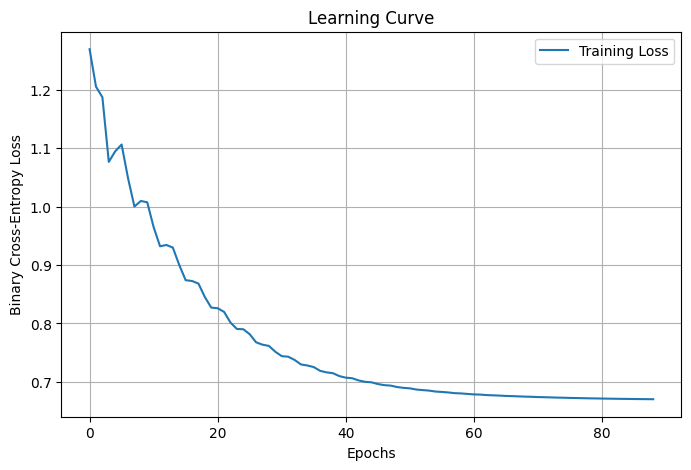

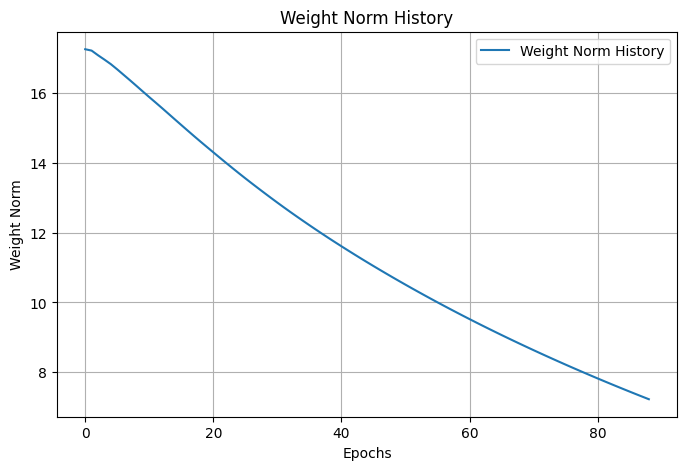

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(weight_norm_history, label="Weight Norm History")
plt.xlabel("Epochs")
plt.ylabel("Weight Norm")
plt.title("Weight Norm History")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc

# The predicted probabilities for the test dataset: test_prediction_probabilities 
# Predicted class labels for the test dataset: predicted_test_classes

true_test_labels = y_test.astype(int)

# Calculate metrics
roc_auc_negative = roc_auc_score(1 - true_test_labels, test_prediction_probabilities_negative)
accuracy = accuracy_score(true_test_labels, predicted_test_classes)
precision = precision_score(true_test_labels, predicted_test_classes, average='binary', pos_label=0)
recall = recall_score(true_test_labels, predicted_test_classes, average='binary', pos_label=0)
f1 = f1_score(true_test_labels, predicted_test_classes, average='binary', pos_label=0)

print("=== Evaluation Metrics ===")
print(f"ROC AUC Score (negative class): {roc_auc_negative:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (negative class): {precision:.4f}")
print(f"Recall (negative class): {recall:.4f}")
print(f"F1 Score (negative class): {f1:.4f}")

print("\n=== Predictions ===")
print(f"Test Prediction Probabilities (for the negative class, threshold not applied): {test_prediction_probabilities_negative}")
print(f"Predicted Test Classes: {predicted_test_classes}")
print(f"True Test Labels: {true_test_labels}")

=== Evaluation Metrics ===
ROC AUC Score (negative class): 0.5121
Accuracy: 0.5250
Precision (negative class): 0.5238
Recall (negative class): 0.5500
F1 Score (negative class): 0.5366

=== Predictions ===
Test Prediction Probabilities (for the negative class, threshold not applied): [0.66646341 0.54005245 0.44583259 0.32756367 0.56606567 0.68561821
 0.12224874 0.44023392 0.67858648 0.5476846  0.49938838 0.48361304
 0.66228281 0.43713842 0.26754365 0.47871152 0.28166165 0.7352232
 0.51883392 0.4047388  0.55115911 0.37234497 0.25315404 0.71372355
 0.63550644 0.46549184 0.71318201 0.58054752 0.53389355 0.75180215
 0.70572573 0.47067325 0.27914043 0.38085822 0.61911171 0.20084168
 0.41485028 0.5157817  0.55511364 0.4727496  0.61433652 0.51025759
 0.34963454 0.32433489 0.19585782 0.33296379 0.45947544 0.3572502
 0.41076825 0.44825606 0.8301772  0.4183799  0.34105774 0.62231154
 0.60986042 0.32621792 0.76216649 0.33694677 0.43904667 0.25577264
 0.3915223  0.35450353 0.65917556 0.68654087 0.5

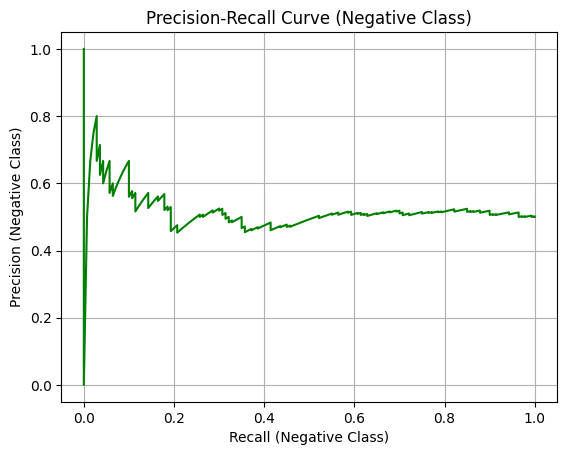

Optimal Threshold (Negative Class): 0.12224874155678456


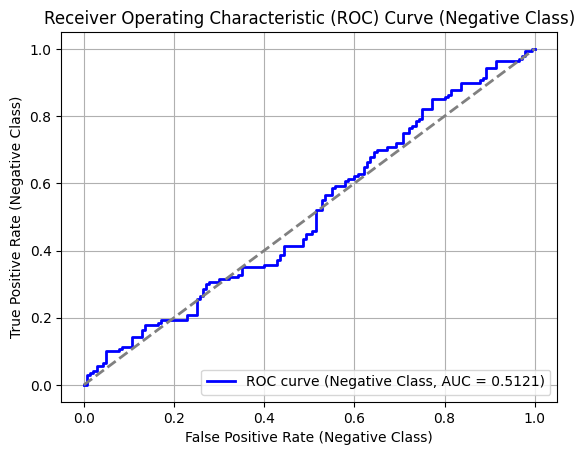

In [11]:
# Precision-recall curve for the negative class
precisions, recalls, thresholds = precision_recall_curve(1 - true_test_labels, test_prediction_probabilities_negative)

plt.figure()
plt.plot(recalls, precisions, color='green')
plt.xlabel('Recall (Negative Class)')
plt.ylabel('Precision (Negative Class)')
plt.title('Precision-Recall Curve (Negative Class)')
plt.grid()
plt.show()

# Optimize threshold where precision and recall are balanced (for negative class)
optimal_idx = (precisions - recalls).argmin()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Negative Class): {optimal_threshold}")

# Compute ROC curve and AUC for the negative class
fpr, tpr, thresholds = roc_curve(1 - true_test_labels, test_prediction_probabilities_negative)
roc_auc_negative = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (Negative Class, AUC = {roc_auc_negative:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # The random guess line
plt.xlabel("False Positive Rate (Negative Class)")
plt.ylabel("True Positive Rate (Negative Class)")
plt.title("Receiver Operating Characteristic (ROC) Curve (Negative Class)")
plt.legend(loc="lower right")
plt.grid()
plt.show()